In [1]:
import os
import re
import openai
import pandas as pd
import tiktoken
import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from langchain.schema import Document
from langchain_pinecone import PineconeVectorStore
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import Pinecone
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Necessary pip installation commands include:
- pip install openai
- pip install pandas
- pip install tiktoken
- pip install numpy
- pip install python-dotenv
- pip install langchain
- pip install langchain-pinecone
- pip install langchain-core
- pip install langchain-openai

#### <b>Note</b>: have a <b>.env</b> file already created for accessing API key

In [2]:
# retrieving API Key from OpenAI platform
load_dotenv()
# Initialize the tokenizer for GPT-3.5 Turbo and GPT-4
tokenizer = tiktoken.get_encoding("cl100k_base")
input_token_cost = ((0.50 / 1000000))
output_token_cost = ((1.50 / 1000000))
FINE_TUNED_TOXIC_DETECTION_API_KEY = os.getenv('FINE_TUNED_TOXIC_DETECTION_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc_index = os.getenv('PINECONE_GPT')

In [3]:
# initializing Pinecone vector database instance
docSearch = Pinecone(
    index_name=pc_index,
    embedding=OpenAIEmbeddings()
)
# instantiating client with API key
fine_tuned = OpenAI(
    api_key=FINE_TUNED_TOXIC_DETECTION_API_KEY
)

C:\Users\elija\AppData\Local\Temp\ipykernel_8468\2326318028.py:2: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.3 and will be removed in 0.3.0. Use :class:`~PineconeVectorStore` instead.
  docSearch = Pinecone(


In [4]:
def remove_repetition(text, depth=0):
    # cap = 5
    # check = 0
    # split_line = line.split(' ')
    # new_split = []
    # curr = split_line[0]
    
    # for word in split_line:
    #     if word == curr:
    #         check = check + 1
    #     else:
    #         curr = word
    #         check = 0
            
    #     if check < cap:
    #         new_split.append(word)

    pattern = r'\b(\w+(?:\s+\w+)*)\b(?:\s+\1\b)+'
    new_text = re.sub(pattern, r'\1', text, flags=re.IGNORECASE)
    
    if new_text == text or depth > 10: 
        return new_text
    return remove_repetition(new_text, depth + 1)
    
    # return " ".join(new_split)

In [5]:
# appends one/few shot examples to evaluation prompt
def shot_additions(examples):
   evaluation_prompt = ''
   # Read the evaluation prompt from the text file with utf-8 encoding
   with open("../../data/text/rag_prompts/gpt-4-two-shot-prompt.txt", "r", encoding="utf-8") as file:
        evaluation_prompt += file.read() 
   count = 1
   for example in examples:
       # separates example key and values
       split_ex = example.split(' - ')
       comment = split_ex[0]
       label = split_ex[1]
       print(f'#{count} shot: {comment}')
       evaluation_prompt += '\n\nText: \"' + remove_repetition(comment) + "\"" + '\n\n' + label
       count += 1
   print(f'Shots added!')
   evaluation_prompt += '\n\nClassify the following comment:'
   return evaluation_prompt

In [6]:
# queries vector database for custom,
# with similar examples to user prompt
def rag_prompt(text):
    two_shots = []
    # queries Pinecone database
    search_results = docSearch.max_marginal_relevance_search(text, k=25, fetch_k=50)
    print(f'Search Results Length: {len(search_results)}')
    for i in range(len(search_results)):
        content = search_results[i].page_content
        # prevents repetition which will cause errors within OpenAI
        if i != 250:
            two_shots.append(content)
        # two valid examples found
        if len(two_shots) == 3:
            print(f'Two Shots Found!')
            break
    return shot_additions(two_shots)

In [7]:
def model_scores_and_metrics(tuned, original, tokens, finetuned=False):
    from sklearn.metrics import (
        roc_auc_score,
    )
    tuned = tuned[['Toxic']]
    predictions = original[['Toxic']]
    # comparing results of model to dataset
    compare = tuned['Toxic'] == original['Toxic']
    accuracy = compare.values.sum() / compare.size
    print(f"Accuracy: {accuracy * 100:.2f}%")
    if finetuned:
        f1 = f1_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        precision = precision_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        roc_auc_score = roc_auc_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        cm = confusion_matrix(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))

        print(f'F1: {f1}')
        print(f'Precision: {precision}')
        print(f'ROC AUC Score: {roc_auc_score}')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')

    # token info
    input_cost = ((tokens['Input'].sum() + tokens['Prompt'].sum()) * input_token_cost)
    output_cost = (tokens['Output'].sum() * output_token_cost)
    total_cost = ((tokens['Input'].sum() + tokens['Prompt'].sum()) * input_token_cost) + (tokens['Output'].sum() * output_token_cost)
    total_tokens = tokens['Total'].sum()

    print(f"Input Tokens: {input_cost}")
    print(f"Output Tokens: {output_cost}")
    print(f"Total Cost: {total_cost}")
    print(f"Total Tokens: {total_tokens}")

In [8]:
# tests accuracy of chosen model against unique prompt and data
def accuracy_testing(data, evaluation_prompt, model, use_rag = False):
    # chooses columns of focus
    tuned = pd.DataFrame(columns=['Text', 'Toxic'])
    tokens = pd.DataFrame(columns=['Prompt', 'Input', 'Output', 'Total'])
    for index, row in data.iterrows():
        text = row['Text']
        prompt_choice = evaluation_prompt if use_rag == False else rag_prompt(remove_repetition(text))
        print(f"Index: {index}")
        print(f'Text: {text}')
        print(f"Starting Completion at Index: {index}")
        completion = fine_tuned.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system", 
                    "content": prompt_choice
                },
                {
                    "role": "user",
                    "content": text
                }
            ]
        )
        print(f'Finished Completion {index}!')
        tuned.loc[index] = [text, completion.choices[0].message.content]
                # tokenize the string
        tokens_object = {
            'prompt': len(tokenizer.encode(prompt_choice)),
            'input': len(tokenizer.encode(row['Text'])),
            'output': len(tokenizer.encode(completion.choices[0].message.content))
        }
        total_tokens = tokens_object['prompt'] + tokens_object['input'] + tokens_object['output']
        tokens.loc[index] = [tokens_object['prompt'], tokens_object['input'], tokens_object['output'], total_tokens]
    # comparing results of model to dataset
    return tuned, data, tokens

In [9]:
sugarai = pd.read_csv('../../data/csv/semi_sugar_ai_toxicity_evaluation_set.csv')
unintended_bias = pd.read_csv('../../data/csv/semi_unintended_bias_toxicity_classification_set.csv')
sugarai['Toxic'] = sugarai['Toxic'].apply(lambda x: str(int(x)))
unintended_bias['Toxic'] = unintended_bias['Toxic'].apply(lambda x: str(int(x)))

In [10]:
evaluation_prompt = ''
# Read the evaluation prompt from the text file with utf-8 encoding
with open("../../data/text/fine_tuned_prompts/gpt-3-5-0125-two-shot-prompt.txt", "r", encoding="utf-8") as file:
    evaluation_prompt += file.read()

In [11]:
# testing accuracy of Sugar AI Toxicity Classification dataset on original model
tuned, original, tokens = accuracy_testing(sugarai, "Detect whether either is 1 for toxic or 0 for non-toxic", "gpt-3.5-turbo-0125")


Index: 0
Text: Youre so full of shit .. and food .
Starting Completion at Index: 0


Finished Completion 0!
Index: 1
Text: Would it be accurate to call this shrimp and gritz ? Looks fantastic !
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: WHY DO LIBERALS HATE AMERICA ? WHY DOES A LIBERAL WORSHIP COMMUNISM ? LIBERALISM is a Severe Disease and Mental Illness Find a Cure Democrats LiberalLogic Leftists LibTard LiberalHypocrisy JoeBiden q7391
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: This subhuman is a liar . Be gone Billenda we know the truth .
Starting Completion at Index: 3
Finished Completion 3!
Index: 4
Text: The world was not worthy for such a good hearted man . Remarkable individual .
Starting Completion at Index: 4
Finished Completion 4!
Index: 5
Text: Ondine is actually a great mix of panik and kalm
Starting Completion at Index: 5
Finished Completion 5!
Index: 6
Text: I 've been called horrible things by Warren supporters . They 're awful .
Starting Completion at Index: 6
Finished Completion 6!
Index: 7
Text: Ye

In [12]:
"""
Accuracy: 41.48%
Input Tokens: 0.023247499999999997
Output Tokens: 0.0071715
Total Cost: 0.030418999999999998
Total Tokens: 51276
"""
model_scores_and_metrics(tuned, original, tokens)

Accuracy: 41.48%
Input Tokens: 0.023247499999999997
Output Tokens: 0.0071715
Total Cost: 0.030418999999999998
Total Tokens: 51276


In [13]:
# testing accuracy of Sugar AI Toxicity Classification dataset on RAG not fine-tuned
tuned, original, tokens = accuracy_testing(sugarai, evaluation_prompt, "gpt-3.5-turbo-0125", True)

Search Results Length: 25
Two Shots Found!
#1 shot: 1. Youre full shitand food
#2 shot: 31659. Well youre liar outright liar nothing liar cherrypick quotations prove preexisting opinions Youre thick headed jack ass enough sense see need different viewpoints know jump destroy good work without bothering think give consideration anything contrary narrow minded bigoted point view Youre really thick headed jack ass dont know communicate incapable understanding anything contrary narrow minded bigoted point view many low quality articles Wikipedia
#3 shot: 2453. stuff still tastes lousy ice cream Thats certainly sort factoid learn joining participating wwwbobistheoilguycom Perhaps create Bob Oil Guy entry Bob Winters life story draw BITOG crowd mucking worthwhile entries onto much like excrement attracts flies
Shots added!
Index: 0
Text: Youre so full of shit .. and food .
Starting Completion at Index: 0
Finished Completion 0!
Search Results Length: 25
Two Shots Found!
#1 shot: 2. Would accu

In [14]:
"""
Accuracy: 95.79%
Input Tokens: 0.1860125
Output Tokens: 0.001569
Total Cost: 0.18758149999999998
Total Tokens: 373071
"""
model_scores_and_metrics(tuned, original, tokens)

Accuracy: 95.79%
Input Tokens: 0.1860125
Output Tokens: 0.001569
Total Cost: 0.18758149999999998
Total Tokens: 373071


In [15]:
# testing accuracy of Sugar AI Toxicity Classification dataset on fine-tuned model
tuned, original, tokens = accuracy_testing(sugarai, evaluation_prompt, "ft:gpt-3.5-turbo-0125:personal::AujUh1US")


Index: 0
Text: Youre so full of shit .. and food .
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: Would it be accurate to call this shrimp and gritz ? Looks fantastic !
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: WHY DO LIBERALS HATE AMERICA ? WHY DOES A LIBERAL WORSHIP COMMUNISM ? LIBERALISM is a Severe Disease and Mental Illness Find a Cure Democrats LiberalLogic Leftists LibTard LiberalHypocrisy JoeBiden q7391
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: This subhuman is a liar . Be gone Billenda we know the truth .
Starting Completion at Index: 3
Finished Completion 3!
Index: 4
Text: The world was not worthy for such a good hearted man . Remarkable individual .
Starting Completion at Index: 4
Finished Completion 4!
Index: 5
Text: Ondine is actually a great mix of panik and kalm
Starting Completion at Index: 5
Finished Completion 5!
Index: 6
Text: I 've been called horrible things by Warren supporters . They '

Accuracy: 95.09%
F1: 0.9526570048309179
Precision: 0.9879759519038076
ROC AUC Score: 0.9533945532079859
Input Tokens: 0.0631675
Output Tokens: 0.001497
Total Cost: 0.0646645
Total Tokens: 127333


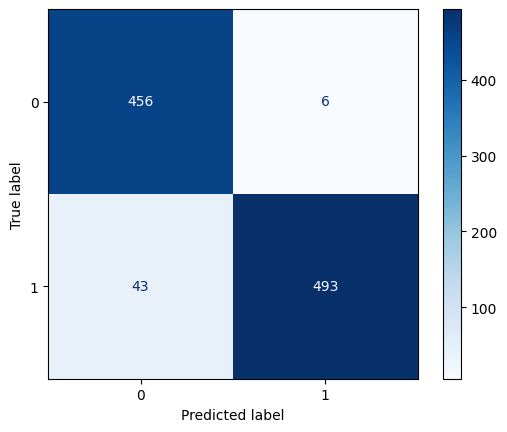

In [16]:
"""
Accuracy: 95.09%
F1: 0.9526570048309179
Precision: 0.9879759519038076
ROC AUC Score: 0.9533945532079859
Input Tokens: 0.0631675
Output Tokens: 0.001497
Total Cost: 0.0646645
Total Tokens: 127333
"""
model_scores_and_metrics(tuned, original, tokens, True)

In [17]:
# testing accuracy of Unintended Sugar AI Toxicity Classification dataset on fine-tuned model with RAG
tuned, original, tokens = accuracy_testing(sugarai, evaluation_prompt, "ft:gpt-3.5-turbo-0125:personal::AujUh1US", True)


Search Results Length: 25
Two Shots Found!
#1 shot: 1. Youre full shitand food
#2 shot: 31659. Well youre liar outright liar nothing liar cherrypick quotations prove preexisting opinions Youre thick headed jack ass enough sense see need different viewpoints know jump destroy good work without bothering think give consideration anything contrary narrow minded bigoted point view Youre really thick headed jack ass dont know communicate incapable understanding anything contrary narrow minded bigoted point view many low quality articles Wikipedia
#3 shot: 2453. stuff still tastes lousy ice cream Thats certainly sort factoid learn joining participating wwwbobistheoilguycom Perhaps create Bob Oil Guy entry Bob Winters life story draw BITOG crowd mucking worthwhile entries onto much like excrement attracts flies
Shots added!
Index: 0
Text: Youre so full of shit .. and food .
Starting Completion at Index: 0
Finished Completion 0!
Search Results Length: 25
Two Shots Found!
#1 shot: 2. Would accu

Accuracy: 94.59%
F1: 0.9444444444444444
Precision: 0.9198396793587175
ROC AUC Score: 0.9471056075707239
Input Tokens: 0.18611149999999999
Output Tokens: 0.001497
Total Cost: 0.18760849999999998
Total Tokens: 373221


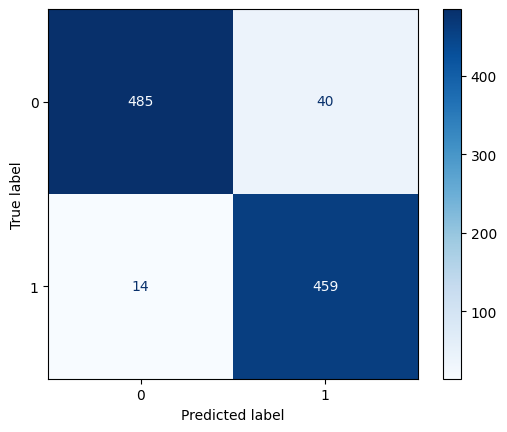

In [18]:
"""
Accuracy: 94.59%
F1: 0.9444444444444444
Precision: 0.9198396793587175
ROC AUC Score: 0.9471056075707239
Input Tokens: 0.18611149999999999
Output Tokens: 0.001497
Total Cost: 0.18760849999999998
Total Tokens: 373221
"""
model_scores_and_metrics(tuned, original, tokens, True)

In [19]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on original model
tuned, original, tokens = accuracy_testing(unintended_bias, "Detect whether either is 1 for toxic or 0 for non-toxic", "gpt-3.5-turbo-0125")


Index: 0
Text: Give us Pharrell Williams and others of his caliber . Now that would really rock . Or Lightening BOLT , the Olympic winner ! We want talent not trash .
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: There has been polling on this , and support among Canadians for assisted suicide exceeds 80 . Sadly , some folk choose to end their lives early , while they still can , rather than be stuck without it once they can no longer do it for themselves . So , ironically , the opponents are actually expediting some deaths . Research has also shown that lots of people , once they get approval , actually choose not to go through with it . But just knowing the option was available gave them peace of mind .
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: Even with all the protective gear you wear , StephBand , it wo n't protect you against an inattentive driver , especially the hit and run drivers .
Starting Completion at Index: 2
Finished Co

In [20]:
"""
Accuracy: 29.80%
Input Tokens: 0.0400395
Output Tokens: 0.009273
Total Cost: 0.049312499999999995
Total Tokens: 86261
"""
model_scores_and_metrics(tuned, original, tokens)

Accuracy: 29.80%
Input Tokens: 0.0400395
Output Tokens: 0.009273
Total Cost: 0.049312499999999995
Total Tokens: 86261


In [21]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on RAG not fine-tuned model
tuned, original, tokens = accuracy_testing(unintended_bias, evaluation_prompt, "gpt-3.5-turbo-0125", True)

Search Results Length: 25
Two Shots Found!
#1 shot: 12429. stupidity receive award attacking horrible coldplay rock group whose popularity must based upon hooking McDonalds Holiday Inn seems music groups get attention USA go bed big corporation editor nerve revoke edits Russian female musician even though admits limited musical knowledge Somebody needs remove tags listing leave alone would make mad see listing removed threatened would ultimate sin mean whole notability issue senseless coldplay notable selling records quality somehow Wikipedia needs pay attention quality less attention whether rock musician sells lot tshirts Walmart Iowa lol Hell Wikipedia lists artist sold one CD CD high quality something far superior coldplay say list musician sold one CD erase coldplay seem like might get seem like somebody might common sense although photo sure strange
#2 shot: 215. Largely meaningless victory Gatlin much like beating Michael Jordan final game member Washington Wizards couldnt beat 

In [22]:
"""
Accuracy: 62.10%
Input Tokens: 0.1863345
Output Tokens: 0.0015105000000000001
Total Cost: 0.18784499999999998
Total Tokens: 373676
"""
model_scores_and_metrics(tuned, original, tokens)

Accuracy: 62.10%
Input Tokens: 0.1863345
Output Tokens: 0.0015105000000000001
Total Cost: 0.18784499999999998
Total Tokens: 373676


In [23]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on fine-tuned model
tuned, original, tokens = accuracy_testing(unintended_bias, evaluation_prompt, "ft:gpt-3.5-turbo-0125:personal::AujUh1US")


Index: 0
Text: Give us Pharrell Williams and others of his caliber . Now that would really rock . Or Lightening BOLT , the Olympic winner ! We want talent not trash .
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: There has been polling on this , and support among Canadians for assisted suicide exceeds 80 . Sadly , some folk choose to end their lives early , while they still can , rather than be stuck without it once they can no longer do it for themselves . So , ironically , the opponents are actually expediting some deaths . Research has also shown that lots of people , once they get approval , actually choose not to go through with it . But just knowing the option was available gave them peace of mind .
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: Even with all the protective gear you wear , StephBand , it wo n't protect you against an inattentive driver , especially the hit and run drivers .
Starting Completion at Index: 2
Finished Co

Accuracy: 70.60%
F1: 0.6892177589852009
Precision: 0.652
ROC AUC Score: 0.7084311408266015
Input Tokens: 0.0800395
Output Tokens: 0.0015
Total Cost: 0.0815395
Total Tokens: 161079


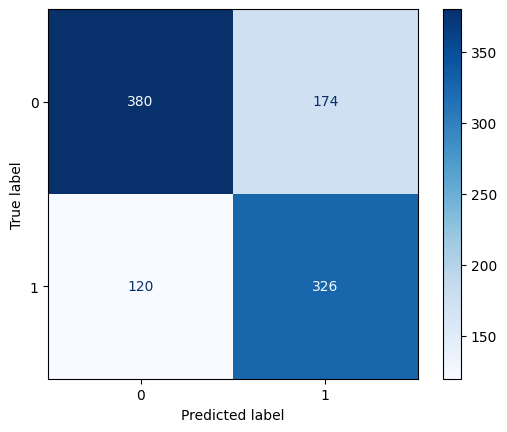

In [24]:
"""
Accuracy: 70.60%
F1: 0.6892177589852009
Precision: 0.652
ROC AUC Score: 0.7084311408266015
Input Tokens: 0.0800395
Output Tokens: 0.0015
Total Cost: 0.0815395
Total Tokens: 161079
"""
model_scores_and_metrics(tuned, original, tokens, True)

In [25]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on fine-tuned model with RAG
tuned, original, tokens = accuracy_testing(unintended_bias, evaluation_prompt, "ft:gpt-3.5-turbo-0125:personal::AujUh1US", True)


Search Results Length: 25
Two Shots Found!
#1 shot: 12429. stupidity receive award attacking horrible coldplay rock group whose popularity must based upon hooking McDonalds Holiday Inn seems music groups get attention USA go bed big corporation editor nerve revoke edits Russian female musician even though admits limited musical knowledge Somebody needs remove tags listing leave alone would make mad see listing removed threatened would ultimate sin mean whole notability issue senseless coldplay notable selling records quality somehow Wikipedia needs pay attention quality less attention whether rock musician sells lot tshirts Walmart Iowa lol Hell Wikipedia lists artist sold one CD CD high quality something far superior coldplay say list musician sold one CD erase coldplay seem like might get seem like somebody might common sense although photo sure strange
#2 shot: 215. Largely meaningless victory Gatlin much like beating Michael Jordan final game member Washington Wizards couldnt beat 

Accuracy: 69.00%
F1: 0.6836734693877551
Precision: 0.67
ROC AUC Score: 0.6903044871794871
Input Tokens: 0.186406
Output Tokens: 0.0015
Total Cost: 0.187906
Total Tokens: 373812


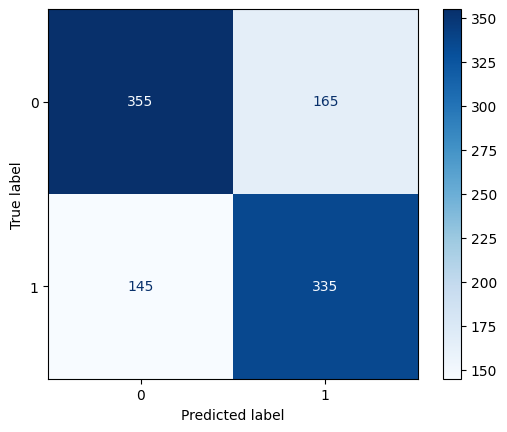

In [26]:
"""
Accuracy: 69.00%
F1: 0.6836734693877551
Precision: 0.67
ROC AUC Score: 0.6903044871794871
Input Tokens: 0.186406
Output Tokens: 0.0015
Total Cost: 0.187906
Total Tokens: 373812
"""
model_scores_and_metrics(tuned, original, tokens, True)